In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from ipfn import ipfn
from matplotlib import pyplot as plt
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error

provider = OriginDestinationEmploymentDataProvider()

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [2]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [4]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
    centroid_all.loc[centroid_all.distance == 0, 'distance'] = 0.2
    
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [5]:
target_columns = ['S000']
for city, state, conties in cities:
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
    training_set.to_csv('cities/%s.csv'%city,index=False)

New York City


In [6]:
training_set

,origin,destination,distance,residence,jobs,flow
0,36081046200,36081046200,0.200000,2465,626.0,36.0
1,36081046200,36081045000,1.495202,2465,108.0,9.0
2,36081046200,36081045400,0.745343,2465,672.0,11.0
3,36081046200,36081045500,6.921982,2465,3204.0,1.0
4,36081046200,36081045600,0.908050,2465,166.0,1.0
...,...,...,...,...,...,...
4652644,36061016900,36081108500,15.561711,3612,199.0,0.0
4652645,36061016900,36081109300,17.079384,3612,626.0,0.0
4652646,36061016900,36081141700,15.923367,3612,905.0,0.0
4652647,36061016900,36081006202,16.638421,3612,498.0,0.0


### doubly constrained, fit u,v together in iterations

In [13]:
def getbins(df, nbins=20):     
    df['bin'] = pd.qcut(df['distance'], q=20)
    df.sort_values(by='bin', inplace=True)
    df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    
    return df
def balancing(test,target,iterationNum,iteration = 20):
#     print(target,'iteration', iterationNum)
    if target+'B' not in test.columns:
        test[target+'B'] = 1
    test[target+'BDF'] = test[target+'jobs']*test[target+'f(d)']*test[target+'B']
    if target+'A' in test.columns:
        del test[target+'A']
    del test[target+'B']
    test = test.groupby(['origin']).agg({target+'BDF':sum}).\
    rename(columns={target+'BDF':target+'A'}).reset_index().\
    merge(test,on=['origin'],how='right')
    test[target+'A'] = 1/test[target+'A']
    test[target+'AOF'] = test[target+'residence']*test[target+'f(d)']*test[target+'A']
    test = test.groupby(['destination']).agg({target+'AOF':sum}).\
    rename(columns={target+'AOF':target+'B'}).reset_index().\
    merge(test,on=['destination'],how='right')
    test[target+'B'] = 1/test[target+'B']
    test[target+'pred'] = test[target+'residence']*test[target+'jobs']*test[target+'f(d)']*\
                        test[target+'A']*test[target+'B']
    
    resultO = test[['origin',target+'residence']].drop_duplicates().\
    merge(test.groupby(['origin'])[[target+'pred']].sum().reset_index(),on=['origin'],how='left')
    resultO['percentage'] = np.abs(resultO[target+'residence'] - resultO[target+'pred'])/resultO[target+'residence']
    resultO = resultO['percentage'].mean()

    resultD = test[['destination',target+'jobs']].drop_duplicates().\
    merge(test.groupby(['destination'])[[target+'pred']].sum().reset_index(),on=['destination'],how='left')
    resultD['percentage'] = np.abs(resultD[target+'jobs'] - resultD[target+'pred'])/resultD[target+'jobs']
    resultD = resultD['percentage'].mean()
#     print(resultO,resultD)
    if resultO < 0.05 and resultD < 0.05:
        return test
    else:
        if iterationNum < iteration:
            return balancing(test,target,iterationNum = iterationNum+1,iteration = 20)
        else:
            return test
        
def doubly_constrained_model_AB(data,target):
    

    binoutput = pd.DataFrame()
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'residence'] * subData[target+'jobs']

        y = subData[target+'flow']

        model = sm.OLS(y,X).fit()

        subData[target+'f(d)'] = model.params[0]       
        binoutput = pd.concat([binoutput,subData])
    binoutput = balancing(binoutput,target,iterationNum=1,iteration = 20)
    binoutput = binoutput[['origin','destination',target+'flow',target+'pred']]

#         binoutput = binoutput[['origin','destination',target+'flow',target+'A',target+'B',target+'f(d)','bin',target+'flowPred']]
       

    return binoutput

In [ ]:
!mkdir constrainCTdistbinsAB
outputDir = 'constrainCTdistbinsAB/'
cities = os.listdir('cities/')
separate_income = False
for city in cities:
    if '.csv' in city:
        df = pd.read_csv('cities/'+city)
        
        dataUV = doubly_constrained_model_AB(getbins(df),'S000')
        dataUV.to_csv(outputDir+city,index=False)


# baseline

### unconstrain model, power law

In [30]:
import scipy.optimize as optimize
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def unconstrained_powerlaw(data,target):

    X = data[['distance',target+'jobs',target+'residence']].values
    y = data[target+'flow'].values
    pars, cov = optimize.curve_fit(f=power_law, xdata=X, ydata=y, bounds=(-np.inf, np.inf))
#         print(pars)
    data[target+'k'] = pars[0]
    data[target+'a'] = pars[1]
    data[target+'pred'] = data[target+'k']*(data['distance']**data[target+'a'])*data[target+'jobs']*data[target+'residence']
    #data = data[['origin', 'destination', target+'flow', target+'pred']]
    return data

In [10]:
training_set.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
predicted_pl = unconstrained_powerlaw(training_set, 'S000')
mean_squared_error(predicted_pl.S000flow, predicted_pl.S000pred)

4.475362699925268

In [ ]:
!mkdir unconstrainCTPowerlaw/
cities = os.listdir('cities/')
citiesDir = 'cities/'

outputDir = 'unconstrainCTPowerlaw/'

for city in cities:
    if '.csv' in city:
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        dataUV = unconstrained_powerlaw(df,target='S000')
        dataUV.to_csv(outputDir+city,index=False)


### unconstrain model, full power law

In [14]:

def power_law(x,k,a,b,c):
    return k*(x[:,0]**a)*(x[:,1]**b)*(x[:,2]**c)
def unconstrained_fullpowerlaw(data, target):
    X = data[['distance',target+'jobs',target+'residence']].values
    y = data[target+'flow'].values
    pars, cov = optimize.curve_fit(f=power_law, xdata=X, ydata=y, bounds=(-np.inf, np.inf))
#         print(pars)
    data[target+'k'] = pars[0]
    data[target+'a'] = pars[1]
    data[target+'b'] = pars[2]
    data[target+'c'] = pars[3]
    data[target+'pred'] = data[target+'k']*(data['distance']**data[target+'a'])*\
                    (data[target+'jobs']**data[target+'b'])*(data[target+'residence']**data[target+'c'])
    #data = data[['origin', 'destination', target+'flow', target+'pred']]
    return data

        

In [15]:
training_set.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
predicted_pl = unconstrained_fullpowerlaw(training_set, 'S000')
mean_squared_error(predicted_pl.S000flow, predicted_pl.S000pred)

4.449022161344106

In [ ]:
!mkdir unconstrainCTFullPowerlaw/
cities = os.listdir('cities/')
citiesDir = 'cities/'

outputDir = 'unconstrainCTFullPowerlaw/'

for city in cities:
    if '.csv' in city:
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        dataUV = unconstrained_fullpowerlaw(df,target='S000')
        dataUV.to_csv(outputDir+city,index=False)


# Bucketed unconstrained power law

In [124]:
def bucketed_power_law(data, bins = 20):
    target = 'S000'
    data['bin'] = pd.qcut(data['distance'], q=bins)
    predictions_all = pd.DataFrame()
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        prediction = unconstrained_powerlaw(subData, target)
        predictions_all = pd.concat([predictions_all, prediction])
    
    return predictions_all

In [125]:
training_set.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
predicted_bfpl = bucketed_power_law(training_set, bins=20)
grouped_bfpl = predicted_bfpl.groupby('bin').agg({'S000k': 'min', 'S000a': 'min'})
grouped_bfpl = grouped_bfpl.reset_index()
mean_squared_error(predicted_bfpl.S000flow, predicted_bfpl.S000pred)

4.451453953880384

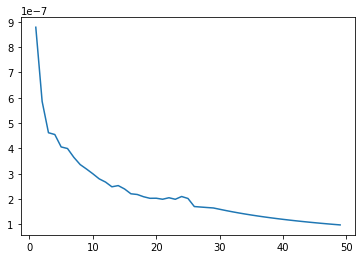

In [129]:
def f(d, boundaries):
    for index, row in boundaries.iterrows():
        if d in row['bin']:
            return row['S000k']*(d**row['S000a'])

x=list(range(1, 50))
y = []
for i in x:
  y.append(f(i, grouped_bfpl)) 

plt.plot(x, y)